(ADBLUCO)=

# 3.2 Algoritmos de descenso y búsqueda de línea en *Unconstrained Convex Optimization* (UCO)

```{admonition} Notas para contenedor de docker:

Comando de docker para ejecución de la nota de forma local:

nota: cambiar `<ruta a mi directorio>` por la ruta de directorio que se desea mapear a `/datos` dentro del contenedor de docker.

`docker run --rm -v <ruta a mi directorio>:/datos --name jupyterlab_optimizacion -p 8888:8888 -d palmoreck/jupyterlab_optimizacion:2.1.4`

password para jupyterlab: `qwerty`

Detener el contenedor de docker:

`docker stop jupyterlab_optimizacion`

Documentación de la imagen de docker `palmoreck/jupyterlab_optimizacion:2.1.4` en [liga](https://github.com/palmoreck/dockerfiles/tree/master/jupyterlab/optimizacion).

```

---

Nota generada a partir de [liga](https://drive.google.com/file/d/16-_PvWNaO0Zc9x04-SRsxCRdn5fxebf2/view).

```{admonition} Al final de esta nota el y la lectora:
:class: tip

* Comprenderá el uso de la información de primer y segundo orden para resolver problemas *small scale* de minimización de funciones convexas mediante los algoritmos general de descenso y de búsqueda de línea por *backtracking*.

* Aprenderá la importancia y relación con ecuaciones no lineales al resolver los problemas que involucran aproximar mínimos locales de funciones.

```

En esta nota consideramos problemas de optimización *small scale*. Aunque el término *small scale* es ambiguo pues depende la máquina en la que se realice el cómputo e involucra el número de variables o parámetros y cantidad de almacenamiento para datos, tomamos como *small scale* aquel problema de optimización en el que se tiene un número de variables menor o igual a $10^3$.

## Ejemplos de problemas de optimización *small scale*

En optimización la búsqueda del (o los) **óptimo(s)** involucran el cálculo de información de primer o segundo orden, ver {ref}`Definición de función, continuidad y derivada <FCD>`, de la función $f_o$ de acuerdo a lo revisado en los {ref}`resultados útiles<RESUT>`. Tal información para problemas *small scale* es calculada utilizando todos los datos en un enfoque por *batch* o lote.

### Ejemplo

$$\displaystyle \min_{x \in \mathbb{R}^2} x_1^4+2x_1^2x_2+x_2^2$$

In [1]:
import numpy as np
import sympy
from sympy.tensor.array import derive_by_array
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import fmin
import pandas as pd
import cvxpy as cp
from pytest import approx

In [2]:
np.set_printoptions(precision=3, suppress=True)

Los candidatos a ser mínimos los encontramos al calcular el gradiente de $f_o$ que podemos calcular con *SymPy*

In [3]:
x1, x2 = sympy.symbols("x1, x2")

In [4]:
fo_sympy = x1**4+2*x1**2*x2+x2**2

In [5]:
sympy.pprint(fo_sympy)

  4       2        2
x₁  + 2⋅x₁ ⋅x₂ + x₂ 


In [6]:
gf = derive_by_array(fo_sympy, (x1, x2))

In [7]:
sympy.pprint(gf)

⎡    3                2       ⎤
⎣4⋅x₁  + 4⋅x₁⋅x₂  2⋅x₁  + 2⋅x₂⎦


y plantear:

$$
\nabla f_o(x) = 
\left [
\begin{array}{c}
4x_1^3+4x_1x_2\\
2x_1^2+2x_2
\end{array}
\right ]=0
$$

la cual es una ecuación de dos variables y dos incógnitas **no lineal**. Resolviendo para $x_2$ se obtiene la relación: $x_2 = -x_1^2$. Entonces todos los puntos con coordenadas $x = (x_1, x_2)$ que satisfacen tal relación cumplen $\nabla f_o(x) = 0$. ¿Todos serán mínimos locales?

**Gráfica de la superficie $f_o$**

In [8]:
def fo_numpy(x):
    return x[0]**4 + 2*x[0]**2*x[1] + x[1]**2

In [9]:
x1_plot,x2_plot = np.meshgrid(np.linspace(-2,2,100), np.linspace(-2,2,100))
z_plot = x1_plot**4 + 2*x1_plot**2*x2_plot + x2_plot**2

In [10]:
x1_np = 0
x2_np = 0 
z_np = fo_numpy([x1_np, x2_np])
point = (x1_np, x2_np, z_np)

In [11]:
print(point)

(0, 0, 0)


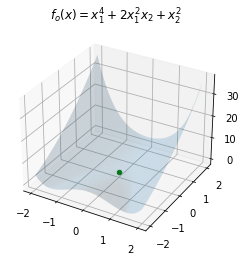

In [12]:
# Create the figure
fig = plt.figure()
# Add an axes
ax = fig.gca(projection='3d')
ax.plot_surface(x1_plot, x2_plot, z_plot, alpha=0.2)
ax.scatter(point[0], point[1], point[2], color='green')
plt.title("$f_o(x) = x_1^4+2x_1^2x_2+x_2^2$")
plt.show()

**Gráfica de las curvas de nivel de $f_o$**

In [13]:
x1_plot,x2_plot = np.meshgrid(np.linspace(-2,2,100), np.linspace(-4, 1,100))
z_plot = x1_plot**4 + 2*x1_plot**2*x2_plot + x2_plot**2

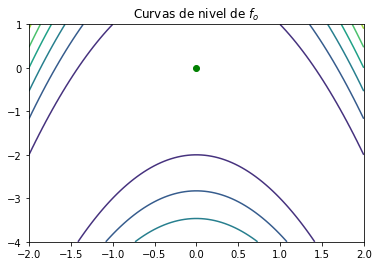

In [14]:
plt.contour(x1_plot,x2_plot,z_plot)
plt.scatter(point[0], point[1], color="green")
plt.title("Curvas de nivel de $f_o$")
plt.show()

Resolvamos con [scipy.optimize.fsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html#scipy.optimize.fsolve) la ecuación no lineal $\nabla f_o(x) = 0$

In [15]:
def eqn(x):
    x1,x2=x
    return [4*x1**3+4*x1*x2, 2*x1**2+2*x2]

```{margin}

Elegimos diferentes puntos iniciales.

```

In [16]:
root1 = fsolve(eqn, (1, 1))

In [17]:
root2 = fsolve(eqn, (-1, 1))

In [18]:
root3 = fsolve(eqn, (2, 0))

In [19]:
dic_roots = {"root1": root1,
             "root2": root2,
             "root3": root3}

```{margin}

Obsérvese que los puntos `root1`, `root2`, `root3` satisfacen la relación $x_2 = -x_1^2$. 

```


In [20]:
print(pd.DataFrame(dic_roots))

   root1  root2  root3
0    1.0   -1.0    2.0
1   -1.0   -1.0   -4.0


Al evaluar el gradiente en cada punto obtenemos cero (o cercano a cero):

In [21]:
gf_eval = lambda x: np.array([partial_derivative.subs({"x1": x[0], 
                                                       "x2": x[1]}) for partial_derivative in gf],
                             dtype=float)

In [22]:
dic = {"root1": gf_eval(root1),
       "root2": gf_eval(root2),
       "root3": gf_eval(root3)}

```{margin}

Los puntos `root1`, `root2` y `root3` resuelven la ecuación no lineal $\nabla f(x) = 0$ .

```

In [23]:
print(pd.DataFrame(dic).round(3))

   root1  root2  root3
0    0.0    0.0    0.0
1    0.0   -0.0    0.0


**¿Cómo podemos identificar si son mínimos? ...** usamos la Hessiana de $f_o$

In [24]:
Hf = derive_by_array(gf, (x1, x2))

In [25]:
sympy.pprint(Hf)

⎡     2             ⎤
⎢12⋅x₁  + 4⋅x₂  4⋅x₁⎥
⎢                   ⎥
⎣    4⋅x₁        2  ⎦


y revisamos eigenvalores de la Hessiana evaluada en los puntos `root1`, `root2`, `root3`

In [26]:
Hf_eval = lambda x: np.array([second_partial_derivative.subs({"x1": x[0], 
                                                              "x2": x[1]}) for second_partial_derivative in Hf],
                             dtype=float)

In [27]:
Hf_root1 = Hf_eval(root1)
Hf_root2 = Hf_eval(root2)
Hf_root3 = Hf_eval(root3)

```{margin}

La Hessiana en `root1` es semidefinida positiva por lo que no podemos concluir que sea mínimo local de $f_o$.

```

In [28]:
print(np.linalg.eigvals(Hf_root1))

[10.  0.]


```{margin}

La Hessiana en `root2` es semidefinida positiva por lo que no podemos concluir que sea mínimo local de $f_o$.

```

In [29]:
print(np.linalg.eigvals(Hf_root2))

[10. -0.]


```{margin}

La Hessiana en `root3` es semidefinida positiva por lo que no podemos concluir que sea mínimo local de $f_o$.

```

In [30]:
print(np.linalg.eigvals(Hf_root3))

[34.  0.]


Tenemos un criterio para $2$ dimensiones:

```{admonition} Comentario

Sea $f \in \mathcal{C}^2(\text{intdom}f)$, $\det(\nabla^2 f(x))$ determinante de la Hessiana y $x \in \mathbb{R}^2$ un punto crítico o estacionario de $f$:

* Si $\frac{\partial^2f(x)}{\partial x_1^2} < 0$ y $\det(\nabla^2 f(x)) >0$ entonces $f$ tiene un **máximo local** en $x$.

* Si $\frac{\partial^2f(x)}{\partial x_1^2} > 0$ y $\det(\nabla^2 f(x)) >0$ entonces $f$ tiene un **mínimo local** en $x$.

* Si $\det(\nabla^2 f(x)) < 0$ entonces $f$ tiene un **punto silla o [*saddle point*](https://en.wikipedia.org/wiki/Saddle_point)** en $x$.

* Si $\det(\nabla^2 f(x)) = 0$ no podemos concluir si $x$ es extremo.

```

```{admonition} Observaciones
:class: tip

* Al determinante de la Hessiana de $f$ se le nombra **Hessiano** de $f$.

* Lo anterior es un caso particular de los resultados descritos en {ref}`sobre puntos críticos <SPCRITICOS>`.

```

En el ejemplo el Hessiano es:

In [31]:
sympy.pprint(sympy.Matrix(Hf).det())

    2       
8⋅x₁  + 8⋅x₂


```{margin}

Los tres puntos `root1`, `root2` y `root3` satisfacen $x_2 = -x_1^2$.

```

El cual se anula justo en los puntos que cumplen: $x_2 = -x_1^2$

$8x_1^2 + 8x_2 = 8 x_1^2 + 8(-x_1^2) = 0$

por lo que no podemos concluir...

Usemos una función de *SciPy* [scipy.optimize.fmin](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html)

```{margin}

Elegimos un punto inicial.

```

In [32]:
res_fmin = fmin(fo_numpy, [1,1])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 56
         Function evaluations: 110


```{margin}

El punto `res_fmin` satisface $\nabla f_o(x) = 0$ y la relación $x_2 = -x_1^2$.

```

In [33]:
print(res_fmin)

[-0.063 -0.004]


In [34]:
print(gf_eval(res_fmin))

[-0.  0.]


In [35]:
Hf_fmin = Hf_eval(res_fmin)

```{margin}

La Hessiana en `res_fmin` es semidefinida positiva por lo que no podemos concluir que sea mínimo local de $f_o$.

```

In [36]:
print(np.linalg.eigvals(Hf_fmin))

[0.    2.032]


Grafiquemos los puntos que cumplen $x_2=-x_1^2$

In [37]:
x1_plot,x2_plot = np.meshgrid(np.linspace(-2,2,100), np.linspace(-4,2,100))
z_plot = x1_plot**4 + 2*x1_plot**2*x2_plot + x2_plot**2

In [38]:
point1 = (root1[0], root1[1], fo_numpy(root1))
point2 = (root2[0], root2[1], fo_numpy(root2))
point3 = (root3[0], root3[1], fo_numpy(root3))
#another point:
point4 = (-2, -4, 0)

In [39]:
x1_plot2 = np.linspace(-2,2,100)

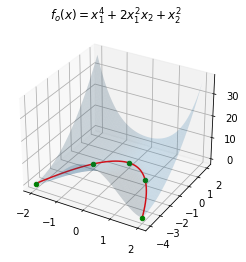

In [40]:
# Create the figure
fig = plt.figure()
# Add an axes
ax = fig.gca(projection='3d')
ax.plot_surface(x1_plot, x2_plot, z_plot, alpha=0.2)
ax.scatter(point[0], point[1], point[2], color='green')
ax.scatter(point1[0], point1[1], point1[2], color='green')
ax.scatter(point2[0], point2[1], point2[2], color='green')
ax.scatter(point3[0], point3[1], point3[2], color='green')
ax.scatter(point4[0], point4[1], point4[2], color='green')
ax.plot(x1_plot2, -x1_plot2**2, color="red")
plt.title("$f_o(x) = x_1^4+2x_1^2x_2+x_2^2$")
plt.show()

Evaluemos en un rango más amplio la función objetivo $f_o$ y realicemos una gráfica

In [41]:
x1_plot,x2_plot = np.meshgrid(np.linspace(-100,100,100), np.linspace(-100,100,100))
z_plot = x1_plot**4 + 2*x1_plot**2*x2_plot + x2_plot**2

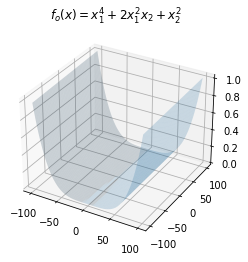

In [42]:
# Create the figure
fig = plt.figure()
# Add an axes
ax = fig.gca(projection='3d')
ax.plot_surface(x1_plot, x2_plot, z_plot, alpha=0.2)
plt.title("$f_o(x) = x_1^4+2x_1^2x_2+x_2^2$")
plt.show()

In [43]:
np.sum(z_plot < 0)

0

**El mínimo valor de $f_o$ es $0$ por lo que tenemos un conjunto de mínimos dados por la curva $x_2=-x_1^2$.**

### ¿Por qué fue un poco complicado determinar el conjunto de mínimos de $f_o$?

**$f_o(x)=x_1^4+2x_1^2x_2+x_2^2$ no es una función convexa en su $\text{dom}f_o$**, $\mathbb{R}^2$, esto es, no satisface la desigualdad:

$$f_o(\theta x + (1-\theta) y) \leq \theta f_o(x) + (1-\theta)f_o(y)$$

$\forall x,y$ en su dominio y $\forall \theta \in [0,1]$.

In [44]:
pointx = np.array([-.5, -1.5])
pointy = np.array([.5, -1.5])
theta = 1/2

In [45]:
point_convex_combination = theta*pointx + (1-theta)*pointy

In [46]:
print(fo_numpy(point_convex_combination))

2.25


```{margin}

Se tiene $f(\theta x + (1-\theta)y) > \theta f(x) + (1-\theta)f(y)$ con la elección $\theta=0.5$, $x=[-0.5, -1.5]^T$, $y=[0.5, -1.5]^T$ lo que indica que $f$ no es convexa sino cóncava para esta elección de puntos $x,y$.

```

In [47]:
print(theta*fo_numpy(pointx) + (1-theta)*fo_numpy(pointy))

1.5625


```{admonition} Observación
:class: tip

Recordar que si $f_o$ es una función convexa, el gradiente de $f_o$ nos ayuda a determinar si un punto es un mínimo local de forma necesaria y suficiente.

```

```{admonition} Ejercicio
:class: tip

Realizar un análisis similar al anterior para la función $f_o(x) = x_2^4+2x_2^2x_1^2+x_1^2$.

```

### Ejemplo importante

$$\displaystyle \min_{x \in \mathbb{R}^2} \frac{1}{2}x^TPx+q^Tx+r$$

donde: $P=\left [\begin{array}{cc} 5 & 4\\ 4 & 5 \end{array} \right ]$, $q=\left [\begin{array}{c} -1\\ 1 \end{array} \right]$, $r=3$.


Haciendo las multiplicaciones de matriz-vector y productos punto


In [48]:
P = sympy.Matrix([[5, 4],
                  [4, 5]])

In [49]:
x = sympy.Matrix(sympy.symbols("x1, x2"))

In [50]:
q = sympy.Matrix([-1,1])


In [51]:
r = 3

In [52]:
fo_sympy = (1/2*x.T*P*x + q.T*x)[0] + r

In [53]:
sympy.pprint(fo_sympy.expand())

      2                          2         
2.5⋅x₁  + 4.0⋅x₁⋅x₂ - x₁ + 2.5⋅x₂  + x₂ + 3


se **reescribe** el problema de optimización como:

$$\displaystyle \min_{x \in \mathbb{R}^2} \frac{5}{2}x_1^2 + \frac{5}{2}x_2^2+4x_1x_2 -x_1 + x_2+3$$ 

La función objetivo es una **función estrictamente convexa** en $\mathbb{R}^2$ (de hecho **fuertemente convexa**) pues:

```{margin}

Los eigenvalores de $P$ son $1$ y $9$ de multiplicidad simple cada uno.

```

In [54]:
sympy.pprint(P.eigenvals())

{1: 1, 9: 1}


y la Hessiana de $f_o$ es:

In [55]:
sympy.pprint(derive_by_array(derive_by_array(fo_sympy, (x1,x2)),
                             (x1,x2))
             )

⎡5.0  4.0⎤
⎢        ⎥
⎣4.0  5.0⎦


El gradiente de $f_o$ es:

In [56]:
sympy.pprint(fo_sympy.diff(x))

⎡5.0⋅x₁ + 4.0⋅x₂ - 1⎤
⎢                   ⎥
⎣4.0⋅x₁ + 5.0⋅x₂ + 1⎦


El mínimo debe satisfacer la ecuación **lineal** con dos variables y dos ecuaciones


$$\nabla f_o(x) = Px +q =\left [ \begin{array}{cc}
5 & 4\\
4 & 5
\end{array}
\right ]
\left [ \begin{array}{c}
x_1\\
x_2
\end{array}
\right ]
+ \left [ \begin{array}{c}
-1\\
1
\end{array}
\right ]=
\left [ \begin{array}{cc}
5x_1+4x_2-1\\
4x_1+5x_2+1
\end{array}
\right ]
=0
$$

```{admonition} Observación
:class: tip

En algunos casos especiales es posible resolver la ecuación no lineal $\nabla f_o(x) = 0$ para $x$ de forma analítica o cerrada. Este es el caso de este ejemplo cuya solución está dada por $x^* = -P^{-1}q$.

```

In [57]:
P = np.array([[5,4],[4,5]])
q = np.array([-1,1])
print(np.linalg.solve(P,-q))

[ 1. -1.]


El problema anterior también lo podemos resolver con [cvxpy](https://github.com/cvxgrp/cvxpy) pues es un **problema convexo**.

```{margin}

Definición de variables y función objetivo: $\frac{1}{2}x^TPx+q^Tx+r$

```

In [58]:
n = 2 #number of variables
x = cp.Variable(n) #optimization variable
fo_cvxpy = (1/2)*cp.quad_form(x, P) + q.T @ x + r#objective function

In [59]:
opt_objective = cp.Minimize(fo_cvxpy) #optimization objective

In [60]:
prob = cp.Problem(opt_objective) #optimization problem

In [61]:
print(prob.solve())

2.000000000000001


In [62]:
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value)

status: optimal
optimal value 2.000000000000001
optimal var [ 1. -1.]


````{admonition} Observaciones
:class: tip

* El paquete cvxpy requiere que se especifique el problema de optimización a resolver siguiendo reglas establecidas en [Disciplined Convex Programming](https://dcp.stanford.edu/). En el ejemplo anterior resulta en un error si se ejecutan las líneas siguientes:

```python
x1 = cp.Variable()
x2 = cp.Variable()
fo = 2.5*x1**2 + 4*x1*x2 - x1 + 2.5*x2**2 + x2 + 3

obj = cp.Minimize(fo)

prob = cp.Problem(obj)

prob.solve()
```

La última línea produce

```
Problem does not follow DCP rules. Specifically: The objective is not DCP.
```

* En la liga de [ejemplos](https://www.cvxpy.org/examples/index.html) hay muchos problemas típicos en optimización convexa y en [Atomic Functions](https://www.cvxpy.org/tutorial/functions/index.html) ejemplos de funciones atómicas que pueden aplicarse a expresiones de *CVXPY*.

````

```{admonition} Ejercicio
:class: tip

Utilizando las herramientas (teóricas y prácticas) del ejemplo anterior, resolver el problema de optimización:

$$\min_{x \in \mathbb{R}^2} ||Ax-b||_2^2$$

con $A=\left [ \begin{array}{ccc} 1 & 6 & 2.5\\ 1 & 2 & 8 \\ 1 & 10 & -1\\ 1 & -9 & 3\\ 1 & -1 & 2 \end{array} \right ]$, $b=\left [ \begin{array}{c} -1 \\ 0 \\ 2 \\ 3.5 \\ -1.7 \end{array} \right ]$.

```

## Métodos de descenso para funciones convexas

Los ejemplos anteriores mostraron la importancia de la información de primer y segundo orden de la función objetivo $f_o$ y las ecuaciones no lineales para resolver el problema de optimización. El primer ejemplo utilizó las funciones [scipy.optimize.fsolve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html#scipy.optimize.fsolve) y [scipy.optimize.fmin](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html) para este propósito. Tales funciones utilizan métodos iterativos para resolver ecuaciones no lineales y aproximar un mínimo local respectivamente en un esquema que para el caso de minimización satisface:

$$f_o(x^{(0)}) > f_o(x^{(1)}) > f_o(x^{(2)}) > \cdots > f_o(x^{(k)}) > \cdots$$

con $x^{(0)}$ punto inicial.

En lo siguiente se asume que $f_o$ cumple $f_o \in \mathcal{C}^2(\text{dom}f_o)$ y es convexa en un conjunto convexo y cerrado que contiene a $x^*$. Ver {ref}`conjunto abierto, cerrado, cerradura e interior <CACCI>` para definición de conjunto cerrado.

### Ejemplo de función objetivo convexa

Encontrar el mínimo del siguiente problema con un **método iterativo**.

$$\displaystyle \min_{x \in \mathbb{R}^4} (x_1-2)^2+(2-x_2)^2+x_3^2+x_4^4$$

In [63]:
x1, x2, x3, x4 = sympy.symbols("x1, x2, x3, x4")

In [64]:
fo_sympy = (x1-2)**2 + (2-x2)**2 + x3**2 + x4**4

In [65]:
gf = derive_by_array(fo_sympy, (x1, x2, x3, x4))

In [66]:
sympy.pprint(gf)

⎡                              3⎤
⎣2⋅x₁ - 4  2⋅x₂ - 4  2⋅x₃  4⋅x₄ ⎦


In [67]:
Hf = derive_by_array(gf, (x1, x2, x3, x4))

In [68]:
sympy.pprint(Hf)

⎡2  0  0    0   ⎤
⎢               ⎥
⎢0  2  0    0   ⎥
⎢               ⎥
⎢0  0  2    0   ⎥
⎢               ⎥
⎢              2⎥
⎣0  0  0  12⋅x₄ ⎦


Como $f_o$ es una función convexa (de hecho **estrictamente convexa**) en su dominio $\mathbb{R}^4$, se tiene que su óptimo se obtiene igualando y resolviendo la **ecuación no lineal** $\nabla f_o(x) = 0$ :

$$\nabla f_o(x) = 
\left[ \begin{array}{c}
2x_1-4 \\
2x_2-4\\
2x_3\\
4x_4^3
\end{array}
\right]
= 0
$$

El óptimo $x^* \in \mathbb{R}^4$ está dado por:

$$x^*=
\left[ \begin{array}{c}
2\\
2\\
0\\
0
\end{array}
\right]
$$

**¿Cómo encontramos numéricamente el óptimo con un método iterativo?**

## Métodos de descenso

Los métodos que utilizan esquemas iterativos para calcular una **secuencia de minimización** de puntos $x^{(0)}, x^{(1)}, \dots \in \text{dom}f_o$ con la característica $f_o(x^{(k)}) \rightarrow p^*$ si $k \rightarrow \infty$ se conocen con el nombre de **métodos de descenso**.


```{admonition} Definición

Un método de descenso es aquel que genera la secuencia de minimización $x^{(0)}, x^{(1)}, \dots \in \text{dom}f_o$ la cual cumple con la desigualdad: $f_o(x^{(k+1)}) < f_o(x^{(k)})$ excepto para $x^{(k)}$ óptimo y $f_o(x^{(k)}) \rightarrow p^*$ si $k \rightarrow \infty$.

```

```{admonition} Observación
:class: tip

La definición de una dirección de descenso anterior aplica para funciones en general, no es necesario que $f_o$ sea convexa.

```

```{margin}

Recuérdese que si $f_o$ es fuertemente convexa en el conjunto $\mathcal{S}$ entonces $\nabla^2 f_o (x) \in \mathbb{S}^n_{++}$ y $\text{cond}(\nabla ^2 f_o(x))$ está acotado por arriba por una constante para $x \in \mathcal{S}$.

```

```{admonition} Comentario

Asumiendo que la función $f_o$ es convexa, típicamente se asume lo siguiente para tener métodos iterativos confiables y exactos:

* Los puntos iniciales $x^{(0)}$ están en $\text{dom}f_o$.

* Que el conjunto $f_o(x^{(0)})$-subnivel sea cerrado pues así se garantiza que la secuencia de minimización está en el conjunto $f_o(x^{(0)})$-subnivel para todas las iteraciones.

* $f_o$ fuertemente convexa en el conjunto $f_o(x^{(0)})$-subnivel para tener propiedades dadas en los {ref}`resultados que son posibles probar para funciones fuertemente convexas <RESFFUERTCON>`. 

```

### Condición para que un paso o dirección de búsqueda sea de descenso

La idea de los métodos de optimización es calcular direcciones $\Delta x$ de búsqueda que sean de descenso, esto es, que al movernos de un punto a otro en tal dirección, el valor de $f_o$ decrece. Existen muchas direcciones de descenso (de hecho infinitas) una que se muestra en el dibujo siguiente es la dirección de descenso de Newton $\Delta x_{nt}$: 

<img src="https://dl.dropboxusercontent.com/s/25bmebx645howjw/direccion_de_descenso_de_Newton_1d.png?dl=0" heigth="600" width="600">

En el dibujo $f = f_o$ y $\hat{f}$ es un **modelo cuadrático**. Del punto $(x,f(x))$ nos debemos mover al punto $(x+\Delta x_{nt}, f(x + \Delta x_{nt}))$ para llegar al óptimo. En tal dirección $f$ decrece: $f(x+\Delta x_{nt}) < f(x)$ y obsérvese que $\Delta x_{nt}$ es mínimo de $\hat{f}$.

```{margin}

Ver {ref}`teorema de Taylor para una función de varias variables <TEOTAYLORNVARIABLES>`

```

```{admonition} Comentario

El modelo cuadrático del dibujo anterior está dado por la aproximación de segundo orden a la función $f_o$ por el teorema de Taylor con centro en $x$:

$$m(x + v) = \hat{f}_o(x + v) = f_o(x) + \nabla f_o(x)^T v + \frac{1}{2} v^T \nabla^2f_o(x)v$$

con único mínimo si $\nabla ^2 f_o(x) \in \mathbb{S}^n_{++}$ dado por $v^* = \Delta x_{nt}$ y $\Delta x_{nt}$ dirección de Newton cuya expresión está más adelante. En cada iteración se construye un modelo cuadrático:

$$m(x^{(k)} + v) = \hat{f}_o(x^{(k)} + v) = f_o(x^{(k)}) + \nabla f_o(x^{(k)})^T v + \frac{1}{2} v^T \nabla^2f_o(x^{(k)})v$$

```

Geométricamente las direcciones de descenso forman un **ángulo agudo** con $-\nabla f_o(x)$:

<img src="https://dl.dropboxusercontent.com/s/o3hypqiociye9jv/zone-for-descent-directions.png?dl=0" heigth="350" width="350">

En el dibujo $f = f_o$.

```{admonition} Observación
:class: tip

Aunque se tienen una cantidad infinita de direcciones de descenso, las direcciones de descenso que típicamente son elegidas no son cercanas a ser ortogonales con el gradiente de $f_o$.

```

Tenemos una condición para garantizar que una dirección sea de descenso:

```{admonition} Definición

Si el paso o dirección de búsqueda satisface: $\nabla f_o(x)^T\Delta x < 0$ se le nombra **dirección de descenso**. 

```

```{margin}

Recuérdese que el teorema de Taylor nos ayuda a aproximar a una función de forma **local**.
```

```{admonition} Comentarios

* Recuérdese que $\nabla f_o(x)^T \Delta x$ es una **derivada direccional** de $f_o$ en $x$ en la dirección $\Delta x$, ver {ref}`ejemplo función restringida a una línea <EJRestriccionALinea>`.

* La definición anterior se justifica pues recuérdese que por la aproximación del teorema de Taylor a primer orden se tiene:

$$f_o(x + \Delta x) \approx f_o(x) + \nabla f_o(x) ^T \Delta x$$

y si $\Delta x$ es dirección de descenso entonces: $f_o(x) + \nabla f_o(x) ^T \Delta x < f_o(x)$.

```

```{admonition} Observación
:class: tip

Obsérvese que si $x^*$ es mínimo local entonces $\nabla f_o(x^*) = 0$ (condición necesaria de primer orden) por lo que no existen direcciones de descenso.

```

### Ejemplos de direcciones de descenso


```{sidebar} La dirección del gradiente...

Una forma de obtener la dirección de Newton es encontrando el mínimo del modelo cuadrático referido anteriormente asumiendo $\nabla ^2 f_o(x) \in \mathbb{S}^n_{++}$. La dirección del gradiente se obtiene al resolver el problema de optimización con restricciones siguiente:

$$\min_{v \in \mathbb{R}^n} \nabla f_o(x)^T v$$

$$\text{sujeto a:} ||v|| = 1$$

para la norma $2$. Se utiliza una restricción del tipo normalización pues la función objetivo involucra un producto punto (derivada direccional) que es dependiente o proporcional a la longitud de $v$.

```

* $\Delta x = - \nabla f_o \left (x^{(k)} \right )$ que da lugar al **método de descenso en gradiente** para $x^{(k)}$ no óptimo.
    
* $\Delta x = - \nabla^2 f_o \left (x^{(k)} \right )^{-1} \nabla f_o\left(x^{(k)} \right)$ que da lugar al **método de descenso por Newton** con $\nabla^2 f_o \left (x^{(k)} \right ) \in \mathbb{S}^n_{++}$ y $x^{(k)}$ no óptimo.
    
* $\Delta x = - H_k ^{-1} \nabla f_o\left(x^{(k)}\right)$  con $H_k$ aproximación a la Hessiana de $f_o$ con $\nabla^2 f_o \left (x^{(k)} \right ) \in \mathbb{S}^n_{++}$ y $x^{(k)}$ no óptimo.


```{admonition} Observaciones
:class: tip

* La definición de una dirección de descenso aplica para funciones en general, no es necesario que $f_o$ sea convexa.

* Para funciones en general, la dirección de Newton es de descenso si la Hessiana es definida positiva y análogamente para las direcciones en las que se utilicen aproximaciones a la Hessiana. Esto asegura que el **modelo cuadrático** tenga un único mínimo y que $f_o$ decrezca su valor en tal dirección.

* Comúnmente los métodos que utilizan aproximaciones a la Hessiana se conocen con el nombre de **métodos Cuasi-Newton**, ver [Quasi-Newton_method](https://en.wikipedia.org/wiki/Quasi-Newton_method).
```

### Continuando con el ejemplo anterior

Encontrar el mínimo del siguiente problema con un **método iterativo**.

$$\displaystyle \min_{x \in \mathbb{R}^4} (x_1-2)^2+(2-x_2)^2+x_3^2+x_4^4$$

**Opción descenso en gradiente**: usando la dirección del gradiente de $f_o$ se tiene: 

$$x^{(k+1)} = x^{(k)} - \nabla f_o(x^{(k)})$$

Tomando $x^{(0)} = \left [ \begin{array}{c} 5 \\ 5 \\1 \\ 0.1 \\ \end{array} \right ]$ como punto inicial:

In [69]:
x_0 = np.array([5,5,1,0.1])

```{margin}

Definición de $f_o$

```

In [70]:
f_o_np = lambda x: (x[0]-2)**2 + (2-x[1])**2 + x[2]**2 + x[3]**2

```{margin}

Evaluando $f_o$ en $x^{(0)}$.

```

In [71]:
print(f_o_np(x_0))

19.01


In [72]:
gf_eval = lambda x: np.array([partial_derivative.subs({"x1": x[0], 
                                                       "x2": x[1],
                                                       "x3": x[2],
                                                       "x4": x[3]}) for partial_derivative in gf],
                              dtype=float)

```{margin}

Evaluando el gradiente en $x^{(0)}$: $\nabla f_o(x^{(0)})$.

```

In [73]:
print(gf_eval(x_0))

[6.    6.    2.    0.004]


```{margin}

Verificando que es dirección de descenso: $\nabla f_o \left (x^{(0)} \right )^T \Delta x < 0$ con $\Delta x = -\nabla f_o \left (x^{(0)} \right )$.

```

In [74]:
print(gf_eval(x_0).dot(-gf_eval(x_0)))

-76.000016


**Primera iteración**

```{margin}

Esquema iterativo: $x_1 = x_0 + \Delta x = x_0 - \nabla f_o(x^{(0)})$.

```

In [75]:
x_1 = x_0 - gf_eval(x_0)

In [76]:
print(x_1)

[-1.    -1.    -1.     0.096]


```{margin}

Evaluando $f_o$ en $x^{(1)}$ se observa que $f_o$ decreció muy poco, de hecho $f_o(x^{(0)}) \approx f_o(x^{(1)})$.

```

In [77]:
print(f_o_np(x_0))

19.01


In [78]:
print(f_o_np(x_1))

19.009216



Obsérvese que la aproximación a primer orden por Taylor no es correcta: $f_o(x_0 + \Delta x) \neq f_o(x_0) + \nabla f_o(x_0)^T \Delta x$.


In [79]:
print(f_o_np(x_0) + gf_eval(x_0).dot(-gf_eval(x_0)))

-56.990016


**Segunda iteración**

```{margin}

Evaluando el gradiente en $x^{(1)}$: $\nabla f_o(x^{(1)})$.

```

In [80]:
print(gf_eval(x_1))

[-6.    -6.    -2.     0.004]


```{margin}

Verificando que es dirección de descenso: $\nabla f_o \left (x^{(1)} \right )^T \Delta x < 0$ con $\Delta x = -\nabla f_o \left (x^{(1)} \right )$.

```

In [81]:
print(gf_eval(x_1).dot(-gf_eval(x_1)))

-76.00001252412463


```{margin}

Esquema iterativo: $x_2 = x_1 + \Delta x = x_1 - \nabla f_o(x^{(1)})$.

```

In [82]:
x_2 = x_1 - gf_eval(x_1)

In [83]:
print(x_2)

[5.    5.    1.    0.092]


```{margin}

Evaluando $f_o$ en $x^{(1)}$ se observa que $f_o$ decreció muy poco, de hecho $f_o(x^{(2)}) \approx f_o(x^{(1)})$.

```

In [84]:
print(f_o_np(x_1))

19.009216


In [85]:
print(f_o_np(x_2))

19.008549046876634


Obsérvese que la aproximación a primer orden por Taylor no es correcta: $f_o(x_1 + \Delta x) \neq f_o(x_1) + \nabla f_o(x_1)^T \Delta x$.


In [86]:
print(f_o_np(x_1) + gf_eval(x_1).dot(-gf_eval(x_1)))

-56.99079652412463


**Tercera iteración**

```{margin}

Esquema iterativo: $x_3 = x_2 + \Delta x = x_2 - \nabla f_o(x^{(2)})$.

```

In [87]:
x_3 = x_2 - gf_eval(x_2)

```{margin}

Obsérvese que $x_3 \approx x_1$.

```

In [88]:
print(x_1)

[-1.    -1.    -1.     0.096]


In [89]:
print(x_3)

[-1.    -1.    -1.     0.089]


**Cuarta iteración**

```{margin}

Esquema iterativo: $x_4 = x_3 + \Delta x = x_3 - \nabla f_o(x^{(3)})$.

```

In [90]:
x_4 = x_3 - gf_eval(x_3)

```{margin}

Obsérvese que $x_4 \approx x_2$.

```

In [91]:
print(x_2)

[5.    5.    1.    0.092]


In [92]:
print(x_4)

[5.    5.    1.    0.086]


y así nos quedaremos ciclando por muchas iteraciones...

```{admonition} Comentario

El método de descenso en gradiente para el ejemplo anterior no convergerá al óptimo $x^* = \left [ \begin{array}{c} 2 \\ 2 \\0 \\ 0 \\ \end{array} \right ]$

```

```{admonition} Ejercicio
:class: tip

¿Converge el método de descenso en gradiente al óptimo para un punto inicial $x^{(0)} = \left [ \begin{array}{c} 2.5 \\ 2.5 \\0.001 \\ 0.001 \\ \end{array} \right ]$?

```

**Opción descenso por dirección de Newton:** usando la dirección de descenso de Newton de $f_o$ se tiene: 

$$x^{(k+1)} = x^{(k)} - \nabla^2 f_o \left (x^{(k)} \right )^{-1} \nabla f_o\left(x^{(k)} \right)$$

Con 

$$
\nabla ^2 f_o(x) = 
\left [ 
\begin{array}{cccc}
2 & 0 & 0 & 0 \\
0 & 2 & 0 & 0 \\
0 & 0 & 2 & 0 \\
0 & 0 & 0 & 12x_4^2
\end{array}
\right ]
$$

Tomando $x^{(0)} = \left [ \begin{array}{c} 5 \\ 5 \\1 \\ 0.1 \\ \end{array} \right ]$ como punto inicial y **no calculando la inversa** de la Hessiana pues en su lugar resolvemos el sistema de ecuaciones lineales $\nabla ^2 f_o \left ( x^{(k)} \right ) \Delta x = - \nabla f_o \left(x^{(k)}\right )$ resulta

In [93]:
x_0 = np.array([5,5,1,0.1])

In [94]:
Hf_eval = lambda x: np.array([second_partial_derivative.subs({"x1": x[0], 
                                                              "x2": x[1],
                                                              "x3": x[2],
                                                              "x4": x[3]}) for second_partial_derivative in Hf],
                             dtype=float)

```{margin}

Evaluando la Hessiana en $x^{(0)}$: $\nabla^2f_o(x^{(0)})$.

```

In [95]:
Hf_sympy_eval = sympy.Matrix(Hf_eval(x_0))
sympy.pprint(Hf_sympy_eval)

⎡2.0  0.0  0.0  0.0 ⎤
⎢                   ⎥
⎢0.0  2.0  0.0  0.0 ⎥
⎢                   ⎥
⎢0.0  0.0  2.0  0.0 ⎥
⎢                   ⎥
⎣0.0  0.0  0.0  0.12⎦


```{margin}

Evaluando el gradiente en $x^{(0)}$: $\nabla f_o(x^{(0)})$.

```

In [96]:
gf_sympy_eval = gf_eval(x_0)
sympy.pprint(gf_sympy_eval)

[6.    6.    2.    0.004]


El sistema de **ecuaciones lineales** a resolver es:

$$
\left [
\begin{array}{cccc}
2 & 0 & 0 & 0 \\
0 & 2 & 0 & 0 \\
0 & 0 & 2 & 0 \\
0 & 0 & 0 & 0.12
\end{array}
\right ]
\Delta x = 
-\left [
\begin{array}{c}
6 \\
6 \\
2 \\
0.004
\end{array}
\right ]
$$

Resolviendo con *NumPy* el sistema de ecuaciones lineales:

```{margin} 

Aquí convertimos de un objeto de *SymPy* a un *array* de *NumPy* pues si bien podríamos resolver el sistema con *SymPy* es menos costoso utilizar *arrays* de *NumPy*.

```

In [97]:
Hf_np_eval = np.array(Hf_sympy_eval, dtype=float)

In [98]:
_, n = Hf_np_eval.shape

```{margin} 

Aquí convertimos de un objeto de *SymPy* a un *array* de *NumPy* pues si bien podríamos resolver el sistema con *SymPy* es menos costoso utilizar *arrays* de *NumPy*.

```

In [99]:
gf_np_eval = np.array(gf_sympy_eval, dtype = float)

In [100]:
gf_np_eval

array([6.   , 6.   , 2.   , 0.004])

```{margin}

Resolvemos $\nabla ^2 f_o \left ( x^{(0)} \right ) \Delta x = - \nabla f_o \left(x^{(0)}\right )$ para obtener $\Delta x$ dirección de Newton.

```

In [101]:
dir_Newton = np.linalg.solve(Hf_np_eval, -gf_np_eval)

In [102]:
print(dir_Newton)

[-3.    -3.    -1.    -0.033]


```{margin}

Verificando que es dirección de descenso: $\nabla f_o \left (x^{(0)} \right )^T \Delta x < 0$ con $\Delta x = -\nabla ^2f_o(x^{(0)})^{-1} \nabla f_o(x^{(0)})$.

```

In [103]:
print(gf_np_eval.dot(dir_Newton))

-38.00013333333333


**Primera iteración**

```{margin}

Esquema iterativo: $x_1 = x_0 + \Delta x = x_0 - \nabla ^2f_o(x^{(0)})^{-1} \nabla f_o(x^{(0)})$

```

In [104]:
x_1 = x_0 + dir_Newton

In [105]:
print(x_1)

[2.    2.    0.    0.067]


Recuérdese que **siempre** es útil monitorear el número de condición de la matriz del sistema de ecuaciones lineales que en este caso es la Hessiana de $f_o$ en $x^{(0)}$ para confiabilidad de nuestros cálculos al resolver el sistema de ecuaciones lineales asociado, ver {ref}`Número de condición de una matriz <NCM>`:

In [106]:
print(np.linalg.cond(Hf_np_eval))

16.666666666666664


```{margin}

Evaluando $f_o$ en $x^{(1)}$ se observa que $f_o$ sí decrece $f_o(x^{(1)}) < f_o(x^{(0)})$.

```

In [107]:
print(f_o_np(x_0))

19.01


In [108]:
print(f_o_np(x_1))

0.004444444444444446


Obsérvese que la aproximación a segundo orden por Taylor es cercana: $f_o(x_0 + \Delta x) \approx f_o(x_0) + \nabla f_o(x_0)^T \Delta x + \frac{1}{2}\Delta x ^T\nabla^2 f_o(x_0) \Delta x$.


In [109]:
print(f_o_np(x_0) + gf_np_eval.dot(dir_Newton) + 1/2*dir_Newton.dot(Hf_np_eval@dir_Newton))

0.009933333333336236


**Segunda iteración**

```{margin}

Evaluando la Hessiana en $x^{(1)}$: $\nabla^2f_o(x^{(1)})$, evaluando el gradiente en $x^{(1)}$: $\nabla f_o(x^{(1)})$ y resolviendo el sistema de ecuaciones $\nabla ^2 f_o \left ( x^{(1)} \right ) \Delta x = - \nabla f_o \left(x^{(1)}\right )$.

```

```{margin}

Esquema iterativo: $x_2 =  x_1 + \Delta x = x_1 - \nabla ^2f_o(x^{(1)})^{-1} \nabla f_o(x^{(1)})$

```

In [110]:
Hf_sympy_eval = sympy.Matrix(Hf_eval(x_1))
gf_sympy_eval = gf_eval(x_1)
Hf_np_eval = np.array(Hf_sympy_eval, dtype=float)
gf_np_eval = np.array(gf_sympy_eval, dtype = float)
dir_Newton = np.linalg.solve(Hf_np_eval, -gf_np_eval)
x_2 = x_1 + dir_Newton

In [111]:
print(x_2)

[2.    2.    0.    0.044]


```{margin}

Verificando que es dirección de descenso: $\nabla f_o \left (x^{(1)} \right )^T \Delta x < 0$ con $\Delta x = -\nabla ^2f_o(x^{(1)})^{-1} \nabla f_o(x^{(1)})$.

```

In [112]:
print(gf_np_eval.dot(dir_Newton))

-2.6337448559670797e-05


```{margin}

Evaluando $f_o$ en $x^{(2)}$ se observa que $f_o$ sí decrece $f_o(x^{(2)}) < f_o(x^{(1)})$.

```

In [113]:
print(f_o_np(x_1))

0.004444444444444446


In [114]:
print(f_o_np(x_2))

0.0019753086419753096


Obsérvese que la aproximación a segundo orden por Taylor es cercana: $f_o(x_1 + \Delta x) \approx f_o(x_1) + \nabla f_o(x_1)^T \Delta x + \frac{1}{2}\Delta x ^T\nabla^2 f_o(x_1) \Delta x$.


In [115]:
print(f_o_np(x_1) + gf_np_eval.dot(dir_Newton) + 1/2*dir_Newton.dot(Hf_np_eval@dir_Newton))

0.004431275720164611


```{margin}

Número de condición de la Hessiana de $f_o$ en $x^{(1)}$.

```

In [116]:
print(np.linalg.cond(Hf_np_eval))

37.499999999999986


**Tercera iteración**

```{margin}

Evaluando la Hessiana en $x^{(2)}$: $\nabla^2f_o(x^{(2)})$, evaluando el gradiente en $x^{(2)}$: $\nabla f_o(x^{(2)})$  y resolviendo el sistema de ecuaciones $\nabla ^2 f_o \left ( x^{(2)} \right ) \Delta x = - \nabla f_o \left(x^{(2)}\right )$.

```

```{margin}

Esquema iterativo: $x_3 = x_2 + \Delta x = x_2 - \nabla ^2f_o(x^{(2)})^{-1} \nabla f_o(x^{(2)})$

```

In [117]:
Hf_sympy_eval = sympy.Matrix(Hf_eval(x_2))
gf_sympy_eval = gf_eval(x_2)
Hf_np_eval = np.array(Hf_sympy_eval, dtype=float)
gf_np_eval = np.array(gf_sympy_eval, dtype = float)
dir_Newton = np.linalg.solve(Hf_np_eval, -gf_np_eval)
x_3 = x_2 + dir_Newton

In [118]:
print(x_3)

[2.   2.   0.   0.03]


```{margin}

Verificando que es dirección de descenso: $\nabla f_o \left (x^{(2)} \right )^T \Delta x < 0$ con $\Delta x = -\nabla ^2f_o(x^{(2)})^{-1} \nabla f_o(x^{(2)})$.

```

In [119]:
print(gf_np_eval.dot(dir_Newton))

-5.202458974749789e-06


```{margin}

Evaluando $f_o$ en $x^{(3)}$ se observa que $f_o$ sí decrece $f_o(x^{(3)}) < f_o(x^{(2)})$.

```

In [120]:
print(f_o_np(x_2))

0.0019753086419753096


In [121]:
print(f_o_np(x_3))

0.0008779149519890264


Obsérvese que la aproximación a segundo orden por Taylor es cercana: $f_o(x_2 + \Delta x) \approx f_o(x_2) + \nabla f_o(x_2)^T \Delta x + \frac{1}{2}\Delta x ^T\nabla^2 f_o(x_2) \Delta x$.


In [122]:
print(f_o_np(x_2) + gf_np_eval.dot(dir_Newton) + 1/2*dir_Newton.dot(Hf_np_eval@dir_Newton))

0.0019727074124879346


```{margin}

Número de condición de la Hessiana de $f_o$ en $x^{(2)}$.

```

In [123]:
print(np.linalg.cond(Hf_np_eval))

84.37499999999997


**Cuarta iteración**

```{margin}

Evaluando la Hessiana en $x^{(3)}$: $\nabla^2f_o(x^{(3)})$, evaluando el gradiente en $x^{(3)}$: $\nabla f_o(x^{(3)})$  y resolviendo el sistema de ecuaciones $\nabla ^2 f_o \left ( x^{(3)} \right ) \Delta x = - \nabla f_o \left(x^{(3)}\right )$.

```

```{margin}

Esquema iterativo: $x_4 = x_3 + \Delta x = x_3 - \nabla ^2f_o(x^{(3)})^{-1} \nabla f_o(x^{(3)})$

```

In [124]:
Hf_sympy_eval = sympy.Matrix(Hf_eval(x_3))
gf_sympy_eval = gf_eval(x_3)
Hf_np_eval = np.array(Hf_sympy_eval, dtype=float)
gf_np_eval = np.array(gf_sympy_eval, dtype = float)
dir_Newton = np.linalg.solve(Hf_np_eval, -gf_np_eval)
x_4 = x_3 + dir_Newton

In [125]:
print(x_4)

[2.   2.   0.   0.02]


```{margin}

Verificando que es dirección de descenso: $\nabla f_o \left (x^{(3)} \right )^T \Delta x < 0$ con $\Delta x = -\nabla ^2f_o(x^{(3)})^{-1} \nabla f_o(x^{(3)})$.

```

```{margin}

Obsérvese que el gradiente y la dirección de Newton son cercanos a ser ortogonales.

```

In [126]:
print(gf_np_eval.dot(dir_Newton))

-1.027646217234526e-06


```{margin}

Evaluando $f_o$ en $x^{(4)}$ se observa que $f_o$ sí decrece $f_o(x^{(4)}) < f_o(x^{(3)})$.

```

In [127]:
print(f_o_np(x_3))

0.0008779149519890264


In [128]:
print(f_o_np(x_4))

0.00039018442310623393


Obsérvese que la aproximación a segundo orden por Taylor es cercana: $f_o(x_3 + \Delta x) \approx f_o(x_3) + \nabla f_o(x_3)^T \Delta x + \frac{1}{2}\Delta x ^T\nabla^2 f_o(x_3) \Delta x$.


In [129]:
print(f_o_np(x_3) + gf_np_eval.dot(dir_Newton) + 1/2*dir_Newton.dot(Hf_np_eval@dir_Newton))

0.000877401128880409


```{margin}

Obsérvese cómo va aumentando el número de condición de la Hessiana conforme nos aproximamos a la solución, en este paso se ha calculado la Hessiana de $f_o$ en $x^{(3)}$.

```

In [130]:
print(np.linalg.cond(Hf_np_eval))

189.84374999999991


In [131]:
print(x_4 == approx(np.array([2,2,0,0.0]), abs=1e-1, rel=1e-1))

True


```{admonition} Comentario

El método por dirección de Newton sí convergerá al óptimo $x^* = \left [ \begin{array}{c} 2 \\ 2 \\0 \\ 0 \\ \end{array} \right ]$ pero la convergencia será lenta.

```

Si hubiéramos elegido como punto inicial $x^{(0)} = \left [ \begin{array}{c} 5 \\ 5 \\1 \\ 0 \\ \end{array} \right ]$

In [132]:
x_0 = np.array([5, 5, 1, 0])

```{margin}

Evaluando la Hessiana en $x^{(0)}$: $\nabla^2f_o(x^{(0)})$.

```

In [133]:
Hf_sympy_eval = sympy.Matrix(Hf_eval(x_0))
sympy.pprint(Hf_sympy_eval)

⎡2.0  0.0  0.0  0.0⎤
⎢                  ⎥
⎢0.0  2.0  0.0  0.0⎥
⎢                  ⎥
⎢0.0  0.0  2.0  0.0⎥
⎢                  ⎥
⎣0.0  0.0  0.0  0.0⎦


```{margin}

Evaluando el gradiente en $x^{(0)}$: $\nabla f_o(x^{(0)})$.

```

In [134]:
gf_sympy_eval = sympy.Matrix(gf_eval(x_0))
sympy.pprint(gf_sympy_eval)

⎡6.0⎤
⎢   ⎥
⎢6.0⎥
⎢   ⎥
⎢2.0⎥
⎢   ⎥
⎣0.0⎦


El sistema de **ecuaciones lineales** a resolver es:

$$
\left [
\begin{array}{cccc}
2 & 0 & 0 & 0 \\
0 & 2 & 0 & 0 \\
0 & 0 & 2 & 0 \\
0 & 0 & 0 & 0
\end{array}
\right ]
\Delta x = 
-\left [
\begin{array}{c}
6 \\
6 \\
2 \\
0
\end{array}
\right ]
$$

**Obsérvese que la última ecuación es redundante por lo que una solución al sistema anterior es considerar $x_4=0$ y resolver:**

$$
\left [
\begin{array}{ccc}
2 & 0 & 0  \\
0 & 2 & 0  \\
0 & 0 & 2  \\
\end{array}
\right ]
\Delta x = 
-\left [
\begin{array}{c}
6 \\
6 \\
2 \\
\end{array}
\right ]
$$

In [135]:
x = sympy.Matrix([x1, x2, x3, x4])

```{margin}

*SymPy* nos permite obtener soluciones a sistemas de ecuaciones lineales que tienen un renglón y columna de ceros.

```

In [136]:
sympy.pprint(sympy.solve(Hf_sympy_eval*x - (-gf_sympy_eval), x))

{x₁: -3.0, x₂: -3.0, x₃: -1.0}


```{margin}

Esquema iterativo: $x_1 = x_0 + \Delta x = x_0 - \nabla ^2f_o(x^{(0)})^{-1} \nabla f_o(x^{(0)})$

```

In [137]:
x_1 = x_0 + np.array([-3, -3, -1, 0])

```{margin}

$x_1$ es el óptimo del problema.

```

In [138]:
print(x_1)

[2 2 0 0]


```{margin}

El número de condición es $\infty$, con el `print` de *SymPy* se ve así.

```

In [139]:
sympy.pprint(Hf_sympy_eval.condition_number())

zoo


In [140]:
print(x_1 == approx(np.array([2,2,0,0.0]), abs=1e-4, rel=1e-4))

True


```{admonition} Comentarios

De acuerdo al ejemplo anterior:

* Utilizar información de primer o segundo orden nos ayuda a encontrar óptimo(s) de funciones.

* El método de descenso en gradiente no converge para el punto inicial elegido. En el caso del método de Newton sí hay convergencia pero es lenta si el punto inicial tiene en la última entrada un número cercano a $0$.

* La ventaja que tiene utilizar la dirección del gradiente vs la dirección de Newton es que el gradiente involucra menos almacenamiento en memoria que el almacenamiento de la Hessiana: $\mathcal{O}(n)$ vs $\mathcal{O}(n^2)$. 

```

### Resolviendo el problema con [*CVXPY*](https://github.com/cvxgrp/cvxpy)

In [141]:
x1 = cp.Variable()
x2 = cp.Variable()
x3 = cp.Variable()
x4 = cp.Variable()

In [142]:
fo_cvxpy = (x1 -2)**2 + (2-x2)**2 + x3**2 + x4**2



In [143]:
obj = cp.Minimize(fo_cvxpy)

prob = cp.Problem(obj)

print(prob.solve())

7.031418247836792e-48


In [144]:
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x1.value, x2.value, x3.value, x4.value)

status: optimal
optimal value 7.031418247836792e-48
optimal var 2.0 2.0 0.0 0.0


## Tamaño o longitud de paso

En el ejemplo anterior en el que se aproximó al mínimo del siguiente problema con el método de Newton

$$\displaystyle \min_{x \in \mathbb{R}^4} (x_1-2)^2+(2-x_2)^2+x_3^2+x_4^4$$

se concluyó que tal método converge de forma lenta y el método de descenso en gradiente no converge para el punto inicial elegido en ambos métodos. La pequeña reducción que se obtenía en $f_o$ por cada iteración fue la razón de tal situación en el caso del descenso en gradiente. Una metodología que resuelve la no convergencia del método de descenso en gradiente utiliza el siguiente esquema iterativo:

$$x^{(k+1)} = x^{(k)} + t^{(k)}\Delta x$$

con $t^{(k)}>0$.

```{admonition} Comentario

Para el caso del método de Newton, la convergencia cuadrática depende además de elegir tamaños de pasos adecuados que:

* las iteraciones vayan aproximándose a $x^*$,

* la función objetivo sea dos veces diferenciable y su Hessiana sea definida positiva en un conjunto abierto que contenga a $x^*$ y sea *Lipschitz* continua en tal conjunto, ver [Lipschitz_continuity ](https://en.wikipedia.org/wiki/Lipschitz_continuity), que ayuda a acotar la diferencia entre $f_o$ y el modelo cuadrático $m$.

```

### Continuando con el ejemplo anterior

Usando el método de descenso en gradiente de $f_o$ y el esquema iterativo: 

$$x^{(k+1)} = x^{(k)} - t^{(k)} \nabla f_o(x^{(k)})$$

con $t^{(0)} = 0.5$ con punto inicial $x^{(0)} = \left [ \begin{array}{c} 5 \\ 5 \\1 \\ 0.1 \\ \end{array} \right ]$ se tiene:

In [145]:
x_0 = np.array([5,5,1,0.1])

In [146]:
t_0=0.5

In [147]:
x_1 = x_0 - t_0*gf_eval(x_0)

In [148]:
print(x_1)

[2.    2.    0.    0.098]


In [149]:
print(x_1 == approx(np.array([2,2,0,0.0]), abs=1e-1, rel=1e-1))

True


por lo que llegamos a aproximar al óptimo en una iteración.

```{admonition} Observación
:class: tip

Para problemas *small scale* el método de Newton o Cuasi-Newton son muy superiores al método de descenso en gradiente. Sin embargo para problemas *large scale* el método de descenso en gradiente es utilizado ampliamente en aplicaciones de *machine learning*.

```

```{admonition} Definición

Al escalar $t^{(k)}$ se le nombra **tamaño o longitud de paso** y siempre es positivo salvo en el caso en que $x^{(k)}$ sea óptimo.

```

El valor $t^{(k)}$ se calcula con metodologías como búsqueda de línea o regiones de confianza, ver [line search](https://en.wikipedia.org/wiki/Line_search), [trust region](https://en.wikipedia.org/wiki/Trust_region) y en esta nota se revisa la búsqueda de línea con *backtracking*.

### ¿Por qué funciona lo anterior?

La condición para que una dirección produzca descenso en $f_o$, $f_o(x^{(k+1)}) < f_o(x^{(k)})$, no es la única para que la secuencia de minimización converja a un mínimo de $f_o$. El siguiente ejemplo muestra el comportamiento del ejemplo trabajado antes en el plano.

Considérese $f_o(x) = x^2$, $x^{(0)} = 2$ y los pasos dados por la secuencia: $(-1)^k(1+2^{-k})$. Entonces:

In [150]:
f_o = lambda x:x**2
n = 10

In [151]:
def minimization_sequence():
    for k in range(n):
        yield (-1)**k*(1+2**(-k))

In [152]:
t = np.linspace(-2.3, 2.3, 100)

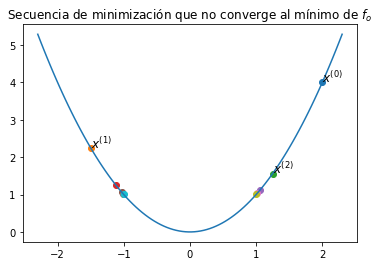

In [153]:
plt.plot(t, f_o(t))
[plt.scatter(s, f_o(s)) for s in minimization_sequence()]
plt.title("Secuencia de minimización que no converge al mínimo de $f_o$")
plt.annotate('$x^{(0)}$',(2, f_o(2)),fontsize=12)
plt.annotate('$x^{(1)}$',(-1.5, f_o(-1.5)),fontsize=12)
plt.annotate('$x^{(2)}$',(1.25, f_o(1.25)),fontsize=12)
plt.show()

para esta secuencia se cumple $f_o(x^{(k+1)}) < f_o(x^{(k)})$ por lo que es una secuencia de minimización pero no converge tal secuencia pues oscila en los valores $\approx -1, 1$.

El problema en este caso es que en cada iteración es muy pequeña la reducción que se obtiene en $f_o$ relativo a la longitud de los pasos. Esto puede arreglarse al requerir que se cumpla una reducción en $f_o$ al moverse de $f_o(x^{(k)})$ hacia $f_o(x^{(k+1)})$ de al menos una cantidad (reducción suficiente).

```{admonition} Comentario

Otra dificultad relacionada con la reducción de $f_o$ y la longitud de los pasos es la situación en la que los pasos sean muy pequeños relativos a la reducción de $f_o$. En la implementación por *backtracking* que se revisa a continuación sólo se soluciona la reducción suficiente de $f_o$.

```

(MBUSLINBACK)=

## Método de búsqueda de línea por *backtracking*

```{margin}

Ver [Backtracking_line_search](https://en.wikipedia.org/wiki/Backtracking_line_search).

```

En esta sección consideramos $f = f_o$. 

La idea del método de búsqueda de línea por *backtracking* es moverse de un punto a otro siguiendo una dirección de descenso con un tamaño de paso completo y si tal tamaño no satisface un criterio entonces realizar un *backtrack* de forma sistemática a lo largo de tal dirección hasta satisfacer el criterio resultando en el tamaño de paso correspondiente.

### Descenso suficiente

Para entender el método de búsqueda de línea por *backtracking* supóngase que $f$ tiene una forma siguiente:

<img src="https://dl.dropboxusercontent.com/s/0woqoj8foo5eco9/level_set_of_func.png?dl=0" heigth="300" width="300">


```{margin}

Un rayo es el conjunto definido por $\{x + \theta v : \theta \geq 0 , v \neq 0, v \in \mathbb{R}^n\}$ para $x \in \mathbb{R}^n$.

<img src="https://dl.dropboxusercontent.com/s/l3z9j49ldzknmif/ej_rayo.png?dl=0" heigth="200" width="200">


```

Y considérese una función $g: \mathbb{R} \rightarrow \mathbb{R}$ igual a $f$ pero restringida al **rayo** $x + t\Delta x$, esto es: $g(t) = f(x+t \Delta x)$ con $t>0$, $\Delta x$ dirección de descenso. Lo anterior se visualiza como sigue:

<img src="https://dl.dropboxusercontent.com/s/18udjmzmmd7drrz/line_search_backtracking_1.png?dl=0" heigth="300" width="300">

```{admonition} Observación
:class: tip

Obsérvese en el dibujo que $\nabla f(x) \neq 0$.

```

```{margin}

Ver {ref}`ejemplo<EJRestriccionALinea>` de la nota {ref}`Definición de función, continuidad y derivada <FCD>` para expresión de la derivada $g'(t)$.

```

Y como $f$ es continua y diferenciable, $g$ también lo es y $g(0)=f(x)$, $g'(t) = \nabla f(x+t\Delta x)^T \Delta x$. Si graficamos $g$ se tendría:

<img src="https://dl.dropboxusercontent.com/s/sgj7eqr2qysi8hs/line_search_backtracking_2.png?dl=0" heigth="300" width="300">


En la búsqueda de línea se construyen dos rectas. Una recta es $g(0) + \alpha g'(0)(t-0)$ con $\alpha \in (0,\frac{1}{2})$. La otra recta es $g(0)+g'(0)(t-0)$. Ambas rectas tienen pendiente negativa. Esto se visualiza como sigue:

<img src="https://dl.dropboxusercontent.com/s/11y008lq0fd6jl6/line_search_backtracking_3.png?dl=0" heigth="500" width="500">


Se busca $t^{(k)}$ tal que $f$ **decrezca suficientemente**. Lo anterior se establece con la desigualdad:

$$f(x+t \Delta x) < f(x) + \alpha t \nabla f(x)^T \Delta x$$

que se nombra **condición de Armijo**:

<img src="https://dl.dropboxusercontent.com/s/o4f341x1y5sqxt8/line_search_backtracking_4.png?dl=0" heigth="500" width="500">


Obsérvese en el dibujo anterior que la región en la que se elegirá $t^{(k)}$ está a la izquierda de la línea punteada vertical de color verde.

Y visualmente en $R^3$ se tiene:

<img src="https://dl.dropboxusercontent.com/s/t3yn7kkpd4il8hx/line_search_backtracking_5.png?dl=0" heigth="300" width="300">



```{admonition} Comentario

La desigualdad de descenso suficiente establece que la reducción debe ser proporcional al tamaño de paso y la derivada direccional $\nabla f(x)^T \Delta x$. 

```

### Algoritmo: búsqueda de línea por *backtracking*


El método depende de dos constantes $\alpha$ y $\beta$ con $\alpha \in (0,\frac{1}{2})$ y $\beta \in (0,1)$. 

> **Dados** $\Delta x$ dirección de descenso para $f$ en $x \in \text{dom}f$, $\alpha \in (0,\frac{1}{2})$, $\beta \in (0,1)$.
>
> **Asignar** t=1.
>
> **Mientras** $f(x+t\Delta x) > f(x) + \alpha t \nabla f(x) ^T\Delta x$.
>>
>> 1. **Reducir** $t: t= \beta t$.


```{admonition} Comentarios 

* El *backtracking* permite tomar tamaños de paso completos, esto es, $t = 1$.

* El valor $\alpha$ típicamente se elige entre $.01$ y $.03$ que indica que se acepta un decrecimiento en el valor de $f$ entre el $1 \%$ y el $30 \%$. La constante $\beta$ comúnmente se elige entre $.1$ (que modifica fuertemente $t$) y $.8$ (que realiza una modificación menos drástica de $t$).

* Aunque la condición de descenso suficiente por sí sola no garantiza que un algoritmo que la utilice realice progreso razonable (pues también hay que añadir una segunda condición para no tomar valores de $t$ muy pequeños) en la implementación del *backtracking* puede incluirse que se revise que $t$ no sea muy pequeño (por ejemplo menor a $10^{-6}$) relativo a $x$, $\Delta x$ y $\nabla f(x)$.

```

## Función en Python para el método de *backtracking*

```python
def line_search_by_backtracking(f,dir_desc,x,
                                der_direct, alpha=.15, beta=.5):
    """
    Line search that sufficiently decreases f restricted to a ray in the direction dir_desc.
    Args:
        alpha (float): parameter in line search with backtracking, tipically .15
        beta (float): parameter in line search with backtracking, tipically .5
        f (lambda expression): definition of function f.
        dir_desc (array): descent direction.
        x (array): numpy array that holds values where line search will be performed.
        der_direct (float): directional derivative of f.
    Returns:
        t (float): positive number for stepsize along dir_desc that sufficiently decreases f.
    """
    t=1
    if alpha > 1/2:
        print("alpha must be less than or equal to 1/2")
        t=-1
    if beta>1:
        print("beta must be less than 1")
        t=-1;   
    if t!=-1:
        eval1 = f(x+t*dir_desc)
        eval2 = f(x) + alpha*t*der_direct
        while eval1 > eval2:
            t=beta*t
            eval1=f(x+t*dir_desc)
            eval2=f(x)+alpha*t*der_direct
    return t
```

```{admonition} Ejercicio
:class: tip

Realizar $5$ iteraciones para minimizar la función $log(e^{x_1^2} + e^{x_2^2})$ del método de descenso en gradiente utilizando búsqueda de línea tomando como punto inicial $(10,1)$ y calcular el error relativo de cada iteración. Para calcular $x^*$ utilizar [cvxpy](https://github.com/cvxgrp/cvxpy).

```

## Algoritmo: método general de descenso para problemas UCO

```{margin}

Los pasos de un algoritmo representan una guía para la implementación, no implica que se tengan que implementar uno a continuación del otro como se describe. Si una implementación respeta la lógica y al mismo algoritmo, entonces pueden seguirse los pasos de una forma distinta.
```

> **Dado** un **punto inicial** $x$ en $\text{dom}f_o$
>
> **Repetir** el siguiente bloque para $k=0,1,2,...$
>>
>> 1. Determinar una dirección de descenso $\Delta x$.
>> 2. Búsqueda de línea. Elegir un tamaño de paso $t > 0$.
>> 3. Hacer la actualización: $x = x + t\Delta x$.
>
> **hasta** convergencia (satisfacer criterio de paro).


```{admonition} Comentarios.

* El algoritmo termina si $f_o(x^{(k)})-p^* \leq \epsilon$ con $\epsilon >0$, esto es, $x^{(k)}$ es $\epsilon$-subóptimo.

* El criterio de paro típicamente es de la forma $||\nabla f_o(x)|| \leq tol$ donde: $tol$ es una cantidad pequeña y positiva (comúnmente menor o igual a $10^{-8}$). También se involucra el número máximo de iteraciones en el criterio de paro.

* El paso $2$ busca reducir $f_o$ lo **suficiente** o minimizarla aproximadamente a lo largo de un rayo. La **búsqueda de línea por [*backtracking*](https://en.wikipedia.org/wiki/Backtracking_line_search)** permite esto.

```

**Preguntas de comprehensión.**

1)¿Qué es un método de descenso?

2)Describe los elementos del esquema iterativo de un método de descenso.

3)¿Cómo se obtiene la dirección de Newton en un método de descenso?

4)¿Cómo se obtiene la dirección del gradiente en un método de descenso?

5)¿Qué es un método Cuasi-Newton?

6)¿Cuál es la condición matemática y geométrica que verifica que un paso de búsqueda sea de descenso?

7)¿Qué situación está resolviendo el método de búsqueda de línea con *backtracking*?


**Referencias:**

1. S. P. Boyd, L. Vandenberghe, Convex Optimization, Cambridge University Press, 2009.


2. J. Dennis, R. B. Schnabel, Numerical Methods for Unconstrained Optimization and Nonlinear Equations, SIAM, 1996.

